# Modeling and Simulation in Python


Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Low pass filter

The following circuit diagram (from [Wikipedia](https://en.wikipedia.org/wiki/File:RC_Divider.svg)) shows a low-pass filter built with one resistor and one capacitor.  

![Low-pass filter circuit diagram](diagrams/RC_Divider.png)

A "filter" is a circuit takes a signal, $V_{in}$, as input and produces a signal, $V_{out}$, as output.  In this context, a "signal" is a voltage that changes over time.

A filter is "low-pass" if it allows low-frequency signals to pass from $V_{in}$ to $V_{out}$ unchanged, but it reduces the amplitude of high-frequency signals.

By applying the laws of circuit analysis, we can derive a differential equation that describes the behavior of this system.  By solving the differential equation, we can predict the effect of this circuit on any input signal.

Suppose we are given $V_{in}$ and $V_{out}$ at a particular instant in time.  By Ohm's law, which is a simple model of the behavior of resistors, the instantaneous current through the resistor is:

$ I_R = (V_{in} - V_{out}) / R $

where $R$ is resistance in ohms.

Assuming that no current flows through the output of the circuit, Kirchhoff's current law implies that the current through the capacitor is:

$ I_C = I_R $

According to a simple model of the behavior of capacitors, current through the capacitor causes a change in the voltage across the capacitor:

$ I_C = C \frac{d V_{out}}{dt} $

where $C$ is capacitance in farads (F).

Combining these equations yields a differential equation for $V_{out}$:

$ \frac{d }{dt} V_{out} = \frac{V_{in} - V_{out}}{R C} $

Follow the instructions blow to simulate the low-pass filter for input signals like this:

$ V_{in}(t) = A \cos (2 \pi f t) $

where $A$ is the amplitude of the input signal, say 5 V, and $f$ is the frequency of the signal in Hz.

### Params and System objects

Here's a `Params` object to contain the quantities we need.  I've chosen values for `R1` and `C1` that might be typical for a circuit that works with audio signal.

In [2]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second

<Unit('second')>

In [3]:
params = Params(
    R1 = 1e6 * ohm,
    C1 = 1e-9 * farad,
    A = 5 * volt,
    f = 1000 * Hz)

,values
R1,1000000.0 ohm
C1,1e-09 farad
A,5 volt
f,1000 hertz


Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

* `omega` is the frequency of the input signal in radians/second.

* `tau` is the time constant for this circuit, which is the time it takes to get from an initial startup phase to 

* `cutoff` is the cutoff frequency for this circuit (in Hz), which marks the transition from low frequency signals, which pass through the filter unchanged, to high frequency signals, which are attenuated.

* `t_end` is chosen so we run the simulation for 4 cycles of the input signal.

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    f, R1, C1 = params.f, params.R1, params.C1
    
    init = State(V_out = 0)
    omega = 2 * np.pi * f
    tau = R1 * C1
    cutoff = 1 / R1 / C1 / 2 / np.pi
    t_end = 4 / f
    ts = linspace(0, t_end, 401)
    
    return System(params, init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff)

Let's make a `System`

In [5]:
system = make_system(params)

,values
R1,1000000.0 ohm
C1,1e-09 farad
A,5 volt
f,1000 hertz
init,V_out 0 dtype: int64
t_end,0.004 / hertz
ts,"[0.0, 1e-05, 2e-05, 3.0000000000000004e-05, 4e..."
omega,6283.185307179586 hertz
tau,0.001 farad * ohm
cutoff,159.15494309189532 / farad / ohm


**Exercise:** Write a slope function that takes as an input a `State` object that contains `V_out`, and returns the derivative of `V_out`.

In [6]:
# Solution

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: V_out
    t: time
    system: System object with A, omega, R1 and C1
    
    returns: dV_out/dt
    """
    V_out, = state
    
    R1, C1 = system.R1, system.C1
    A, omega = system.A, system.omega
    
    V_in = A * np.cos(omega * t)
    
    V_R1 = V_in - V_out
    
    I_R1 = V_R1 / R1
    I_C1 = I_R1

    dV_out = I_C1 / C1
    
    return dV_out

Test the slope function with the initial conditions.

In [7]:
slope_func(system.init, 0*UNITS.s, system)

5000.0 <Unit('volt / farad / ohm')>

And then run the simulation.  I suggest using `t_eval=ts` to make sure we have enough data points to plot and analyze the results. 

In [8]:
results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
details

,values
sol,None
t_events,[]
nfev,110
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


Here's a function you can use to plot `V_out` as a function of time.

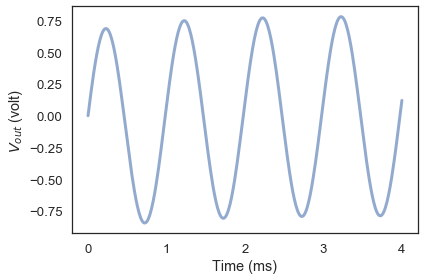

In [9]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)
    
plot_results(results)

If things have gone according to plan, the amplitude of the output signal should be about 0.8 V.

Also, you might notice that it takes a few cycles for the signal to get to the full amplitude. 

### Sweeping frequency

Plot `V_out` looks like for a range of frequencies:

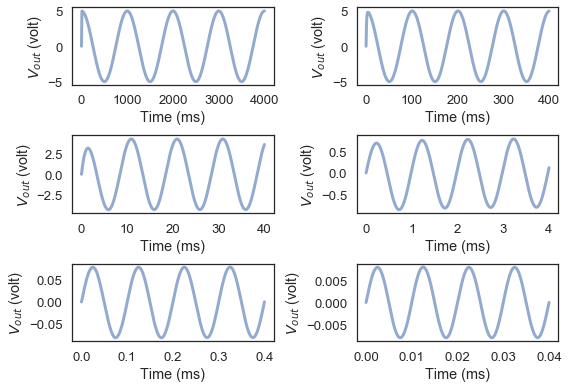

In [10]:
fs = [1, 10, 100, 1000, 10000, 100000] * Hz

for i, f in enumerate(fs):
    system = make_system(Params(params, f=f))
    results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
    subplot(3, 2, i+1)
    plot_results(results)

At low frequencies, notice that there is an initial "transient" before the output gets to a steady-state sinusoidal output.  The duration of this transient is a small multiple of the time constant, `tau`, which is 1 ms.

### Estimating the output ratio

Let's compare the amplitudes of the input and output signals.  Below the cutoff frequency, we expect them to be about the same.  Above the cutoff, we expect the amplitude of the output signal to be smaller.

We'll start with a signal at the cutoff frequency, `f=1000` Hz.

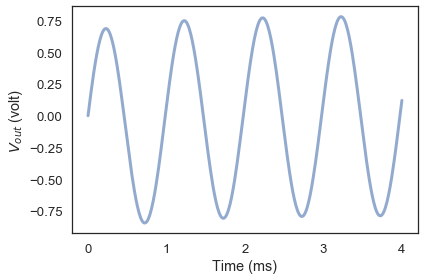

In [11]:
system = make_system(Params(params, f=1000*Hz))
results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
V_out = results.V_out * volt
plot_results(results)

The following function computes `V_in` as a `TimeSeries`:

In [12]:
def compute_vin(results, system):
    """Computes V_in as a TimeSeries.
    
    results: TimeFrame with simulation results
    system: System object with A and omega
    
    returns: TimeSeries
    """
    A, omega = system.A, system.omega
    
    ts = results.index.values * UNITS.second
    V_in = A * np.cos(omega * ts)
    return TimeSeries(V_in, results.index, name='V_in')

Here's what the input and output look like.  Notice that the output is not just smaller; it is also "out of phase"; that is, the peaks of the output are shifted to the right, relative to the peaks of the input.

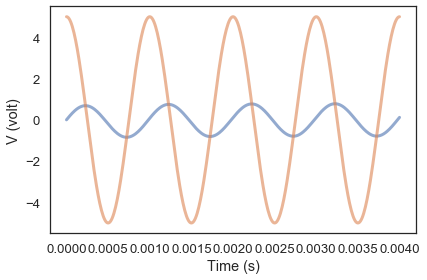

In [13]:
V_in = compute_vin(results, system)

plot(V_out)
plot(V_in)

decorate(xlabel='Time (s)',
         ylabel='V (volt)')

The following function estimates the amplitude of a signal by computing half the distance between the min and max.

In [14]:
def estimate_A(series):
    """Estimate amplitude.
    
    series: TimeSeries
    
    returns: amplitude in volts
    """
    return (series.max() - series.min()) / 2

The amplitude of `V_in` should be near 5 (but not exact because we evaluated it at a finite number of points).

In [15]:
A_in = estimate_A(V_in)

5.0 <Unit('volt')>

The amplitude of `V_out` should be lower.

In [16]:
A_out = estimate_A(V_out)

0.8129812004177154 <Unit('volt')>

And here's the ratio between them.

In [17]:
ratio = A_out / A_in

0.16259624008354306 <Unit('dimensionless')>

**Exercise:** Encapsulate the code we have so far in a function that takes two TimeSeries objects and returns the ratio between their amplitudes.

In [18]:
# Solution

def estimate_ratio(V1, V2):
    """Estimate the ratio of amplitudes.
    
    V1: TimeSeries
    V2: TimeSeries
    
    returns: amplitude ratio
    """
    a1 = estimate_A(V1)
    a2 = estimate_A(V2)
    return a1 / a2

And test your function.

In [19]:
estimate_ratio(V_out, V_in)

0.16259624008354306 <Unit('dimensionless')>

### Estimating phase offset

The delay between the peak of the input and the peak of the output is call a "phase shift" or "phase offset", usually measured in fractions of a cycle, degrees, or radians.

To estimate the phase offset between two signals, we can use cross-correlation.  Here's what the cross-correlation looks like between `V_out` and `V_in`:

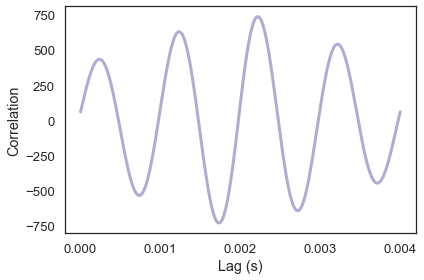

In [42]:
corr = np.correlate(V_out, V_in, mode='same')
corr = TimeSeries(corr, V_in.index)
plot(corr, color='C4')
decorate(xlabel='Lag (s)',
         ylabel='Correlation')

The location of the peak in the cross correlation is the estimated shift between the two signals, in seconds.

In [21]:
peak_time = corr.apply(magnitude).idxmax() * UNITS.second

0.00222 <Unit('second')>

We can express the phase offset as a multiple of the period of the input signal:

In [22]:
period = 1 / system.f

0.001 <Unit('1 / hertz')>

In [23]:
(peak_time / period).to_reduced_units()

2.22 <Unit('dimensionless')>

We don't care about whole period offsets, only the fractional part, which we can get using `modf`:

In [24]:
frac, whole = np.modf(peak_time / period)
frac = frac.to_reduced_units()

0.2200000000000002 <Unit('dimensionless')>

Finally, we can convert from a fraction of a cycle to degrees:

In [25]:
frac * 360 * UNITS.degree

79.20000000000007 <Unit('degree')>

**Exercise:** Encapsulate this code in a function that takes two `TimeSeries` objects and a `System` object, and returns the phase offset in degrees.

Note: by convention, if the output is shifted to the right, the phase offset is negative.

In [26]:
# Solution

def estimate_offset(V1, V2, system):
    """Estimate phase offset.
    
    V1: TimeSeries
    V2: TimeSeries
    system: System object with f
    
    returns: amplitude ratio
    """
    corr = np.correlate(V1, V2, mode='same')
    corr = TimeSeries(corr, V1.index)
    peak_time = corr.apply(magnitude).idxmax() * UNITS.second
    period = 1 / system.f
    frac, whole = np.modf(peak_time / period)
    frac = frac.to_reduced_units()
    return -frac * 360 * UNITS.degree

Test your function.

In [27]:
estimate_offset(V_out, V_in, system)

-79.20000000000007 <Unit('degree')>

### Sweeping frequency again

**Exercise:** Write a function that takes as parameters an array of input frequencies and a `Params` object.

For each input frequency it should run a simulation and use the results to estimate the output ratio (dimensionless) and phase offset (in degrees).

It should return two `SweepSeries` objects, one for the ratios and one for the offsets.

In [28]:
# Solution

def sweep_frequency(fs, params):
    ratios = SweepSeries()
    offsets = SweepSeries()

    for i, f in enumerate(fs):
        system = make_system(Params(params, f=f))
        results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
        V_out = results.V_out
        V_in = compute_vin(results, system)
        
        f = magnitude(f)
        ratios[f] = estimate_ratio(V_out, V_in)
        offsets[f] = estimate_offset(V_out, V_in, system)
    return ratios, offsets

Run your function with these frequencies.

In [29]:
fs = 10 ** linspace(0, 4, 9) * Hz

array([1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04]) <Unit('hertz')>

In [30]:
ratios, offsets = sweep_frequency(fs, params)

We can plot output ratios like this:

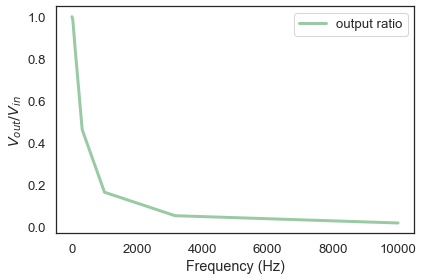

In [31]:
plot(ratios, color='C2', label='output ratio')
decorate(xlabel='Frequency (Hz)',
         ylabel='$V_{out} / V_{in}$')

But it is useful and conventional to plot ratios on a log-log scale.  The vertical gray line shows the cutoff frequency.

In [32]:
def plot_ratios(ratios, system):
    """Plot output ratios.
    """
    # axvline can't handle a Quantity with units
    cutoff = magnitude(system.cutoff)
    plt.axvline(cutoff, color='gray', alpha=0.4)
    
    plot(ratios, color='C2', label='output ratio')
    decorate(xlabel='Frequency (Hz)',
             ylabel='$V_{out} / V_{in}$',
             xscale='log', yscale='log')

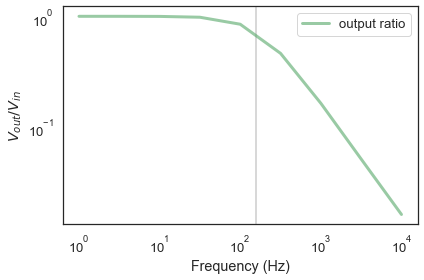

In [33]:
plot_ratios(ratios, system)

This plot shows the cutoff behavior more clearly.  Below the cutoff, the output ratio is close to 1.  Above the cutoff, it drops off linearly, on a log scale, which indicates that output ratios for high frequencies are practically 0.

Here's the plot for phase offset, on a log-x scale:

In [34]:
def plot_offsets(offsets, system):
    """Plot phase offsets.
    """
    # axvline can't handle a Quantity with units
    cutoff = magnitude(system.cutoff)
    plt.axvline(cutoff, color='gray', alpha=0.4)
    
    plot(offsets, color='C9')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase offset (degree)',
             xscale='log')

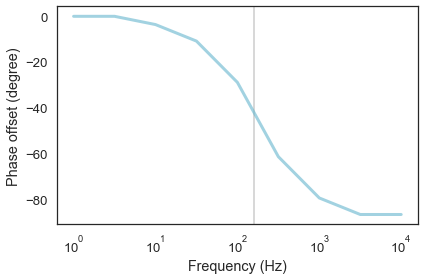

In [35]:
plot_offsets(offsets, system)

For low frequencies, the phase offset is near 0.  For high frequencies, it approaches 90 degrees.

### Analysis

By analysis we can show that the output ratio for this signal is

$A = \frac{1}{\sqrt{1 + (R C \omega)^2}}$ 

where $\omega = 2 \pi f$, and the phase offset is

$ \phi = \arctan (- R C \omega)$ 

**Exercise:** Write functions that take an array of input frequencies and returns $A(f)$ and $\phi(f)$ as `SweepSeries` objects.  Plot these objects and compare them with the results from the previous section.


In [36]:
# Solution

def output_ratios(fs, system):
    R1, C1, omega = system.R1, system.C1, system.omega
    
    omegas = 2 * np.pi * fs
    rco = R1 * C1 * omegas
    A = 1 / np.sqrt(1 + rco**2)
    return SweepSeries(A, magnitude(fs))

Test your function:

In [37]:
A = output_ratios(fs, system)

,values
1.000000,0.9999802613756332 dimensionless
3.162278,0.9998026663382117 dimensionless
10.000000,0.9980319045036448 dimensionless
31.622777,0.9808266593818514 dimensionless
100.000000,0.8467330159648304 dimensionless
316.227766,0.4495645925385784 dimensionless
1000.000000,0.15717672547758985 dimensionless
3162.277660,0.050265590254250286 dimensionless
10000.000000,0.015913478971147695 dimensionless


In [38]:
# Solution

def phase_offsets(fs, system):
    R1, C1, omega = system.R1, system.C1, system.omega

    omegas = 2 * np.pi * fs
    rco = R1 * C1 * omegas
    phi = np.arctan(-rco).to(UNITS.degree)
    return SweepSeries(phi, magnitude(fs))

Test your function:

In [39]:
phi = phase_offsets(fs, system)

,values
1.000000,-0.3599952627020996 degree
3.162278,-1.1382701830745394 degree
10.000000,-3.5952737798681755 degree
31.622777,-11.237840984624153 degree
100.000000,-32.14190763534206 degree
316.227766,-63.284247907949336 degree
1000.000000,-80.95693892096232 degree
3162.277660,-87.1187796579127 degree
10000.000000,-89.08818633038616 degree


Plot the theoretical results along with the simulation results and see if they agree.

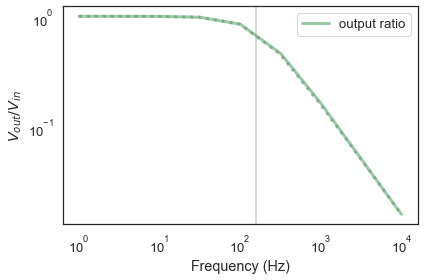

In [40]:
plot(A, ':', color='gray')
plot_ratios(ratios, system)

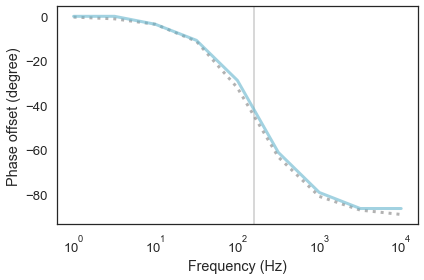

In [41]:
plot(phi, ':', color='gray')
plot_offsets(offsets, system)

For the phase offsets, there are small differences between the theoretical results and our estimates, but that is probably because it is not easy to estimate phase offsets precisely from numerical results.

**Exercise:** Consider modifying this notebook to model a [first order high-pass filter](https://en.wikipedia.org/wiki/High-pass_filter#First-order_continuous-time_implementation), a [two-stage second-order low-pass filter](https://www.electronics-tutorials.ws/filter/filter_2.html), or a [passive band-pass filter](https://www.electronics-tutorials.ws/filter/filter_4.html).